# Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

2024-04-26 18:49:54.172288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 18:49:54.172418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 18:49:54.305563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# read test and train directories

In [2]:
train_dir = "../input/emotion-detection-fer/train" 
test_dir = "../input/emotion-detection-fer/test"   

# Design Model architecture

In [3]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


# show model summary

In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

# generate image data

In [5]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,  
    rescale=1./255,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
img_size=48
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# compile model

In [6]:
model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [7]:
epochs = 30
batch_size = 64
output = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/359 ━━━━━━━━━━━━━━━━━━━━ 2:29:43 25s/step - accuracy: 0.1719 - loss: 2.7057

I0000 00:00:1714157449.039228     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714157449.066709     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


307/359 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 0.1954 - loss: 2.3182

W0000 00:00:1714157556.571391     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1974 - loss: 2.2891

W0000 00:00:1714157572.277449     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 159s 373ms/step - accuracy: 0.1975 - loss: 2.2881 - val_accuracy: 0.1788 - val_loss: 2.0242
Epoch 2/30


W0000 00:00:1714157582.557824     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.2313 - loss: 1.9060 - val_accuracy: 0.2053 - val_loss: 1.8781
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.2707 - loss: 1.8072 - val_accuracy: 0.3275 - val_loss: 1.7306
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.3725 - loss: 1.6082 - val_accuracy: 0.3715 - val_loss: 1.5590
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.4507 - loss: 1.4375 - val_accuracy: 0.4490 - val_loss: 1.4832
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.4908 - loss: 1.3326 - val_accuracy: 0.5405 - val_loss: 1.1933
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.5208 - loss: 1.2572 - val_accuracy: 0.5433 - val_loss: 1.2132
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.5388 - loss: 1.2184 - val_accuracy: 0.5754 - val_loss: 1.1185
Epoch 9/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.5518 - loss: 1.1819 - val_accurac

# create function to preprocess image to test model

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_height = 48
img_width = 48
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    return img_array

# Map each class to a string for clarity

In [22]:
result_map = {0: 'angry', 
                1: 'disgusted',
                2: 'fearful',
                3: 'happy',
                4: 'neutral',
                5: 'sad',
                6: 'surprised'
               }

# test the model on random samples

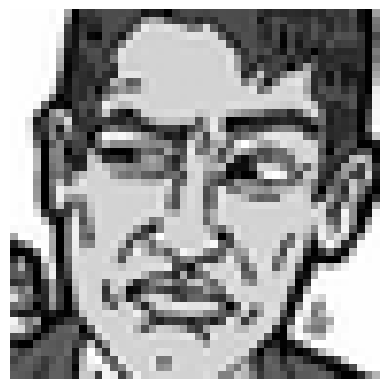

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
angry


In [23]:


image_path = "/kaggle/input/emotion-detection-fer/test/angry/im0.png"
preprocessed_img = preprocess_image(image_path)
img = load_img(image_path, color_mode='grayscale', target_size=(img_height, img_width))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
predicted_emotion = model.predict(preprocessed_img)
predicted_class = tf.argmax(predicted_emotion[0]).numpy()
print(result_map[predicted_class])